In [52]:
# Ensure the project root is in the Python path
import sys
sys.path.append('/Users/tl759k/Documents/GitHub/work/cursor-analytics')

# Activate the virtual environment (if not already activated)
# This is typically done outside the notebook, but we ensure the path is correct here
import os
os.system('source /Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/bin/activate')

# Re-import the SnowflakeHook after ensuring the path is set
from utils.snowflake_connection import SnowflakeHook


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.graph_objects as go
import seaborn as sns
import statsmodels.formula.api as smf
from decimal import Decimal

In [10]:
# Load the SQL query from the file
def load_query(file_path):
    with open(file_path, 'r') as file:
        query = file.read()
    snowhook = SnowflakeHook()
    df = snowhook.query_snowflake(query, method='pandas')

    # format decimal to float
    for col in df.columns:
        if df[col].dtype == 'object' and isinstance(df[col].dropna().iloc[0], Decimal):
            df[col] = df[col].astype(float)

    return df

In [24]:
daco_spend_to_applicants_curve = load_query('daco_spend_to_applicants.sql')
new_dx_landing_curve = load_query('apps_to_new_dx_landing_curve.sql')
new_dx_retention_curve = load_query('new_dx_retention.sql')
global_dx_retention = load_query('global_dx_retention.sql')

daco_spend_to_applicants_curve = daco_spend_to_applicants_curve[daco_spend_to_applicants_curve['forecast_week'] == '2025-10-06'].reset_index(drop = True)

2025-08-21 09:26:23,320 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-08-21 09:26:23,321 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-08-21 09:26:23,754 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-08-21 09:26:23,755 - utils.snowflake_connection - INFO - Executing query (pandas)
2025-08-21 09:26:34,059 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-08-21 09:26:34,059 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-08-21 09:26:34,370 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-08-21 09:26:34,370 - utils.snowflake_connection - INFO - Executing query (pandas)
2025-08-21 09:26:36,747 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-08-21 09:26:36,748 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-08-21 09:26:37,052 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-08-21 09:26:37,052 - utils.snowflake_connection - INFO - Executing query (pandas)
2025-08-21 09:26:46,875 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-08-21 09:26:46,876 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-08-21 09:26:47,611 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-08-21 09:26:47,613 - utils.snowflake_connection - INFO - Executing query (pandas)


In [32]:
# aggregate daco spend to applicants curve
def spend_to_apps(daco_spend_to_applicants_curve, submarket_id):

    df = daco_spend_to_applicants_curve.copy()
    df = df[df['submarket_id'] == submarket_id].reset_index(drop = True)
    df_agg = df.groupby(['forecast_quarter', 'forecast_week','mcpd_scenario','submarket_id']).agg({'spending': 'mean', 'applicants': 'sum', 'new_dx': 'sum'}).reset_index(drop = False)
    df_agg['cost_per_new_dx'] = df_agg['spending'] / df_agg['new_dx']
    df_agg['horizon_spend'] = 0 # assign horizon 0 to all rows

    # check mCPD
    df_agg = df_agg.sort_values(by=['forecast_quarter', 'forecast_week','mcpd_scenario','submarket_id'])
    df_agg['spending_diff'] = df_agg['spending'].diff()
    df_agg['new_dx_diff'] = df_agg['new_dx'].diff()

    # Calculate marginal cost per new dx
    df_agg['marginal_cost_per_new_dx'] = df_agg['spending_diff'] / df_agg['new_dx_diff']

    df_agg['new_dx_ratio_daco'] =  df_agg['new_dx'] / df_agg['applicants']

    df_agg = df_agg[['forecast_quarter', 'forecast_week','mcpd_scenario','submarket_id','spending','applicants','new_dx','cost_per_new_dx','marginal_cost_per_new_dx','new_dx_ratio_daco','horizon_spend']].reset_index(drop = True)

    return df_agg

# new dx landing curve
def apps_to_new_dx(new_dx_landing_curve, df_spend_to_apps):
    df_new_dx = new_dx_landing_curve.merge(df_spend_to_apps, how='cross')
    df_new_dx['new_dx_conv'] = df_new_dx['new_dx_cvr'] * df_new_dx['applicants']
    return df_new_dx


def new_dx_52w(df_new_dx):
    df_new_dx_52w = df_new_dx.groupby(['forecast_quarter','forecast_week', 'mcpd_scenario', 'submarket_id','spending', 'applicants', 'new_dx']).agg({'new_dx_conv': 'sum'}).reset_index(drop = False)
    df_new_dx_52w.rename(columns={'new_dx_conv': 'new_dx_conv_52w'}, inplace=True)
    df_new_dx_26w = df_new_dx[df_new_dx['horizon_conv'] <= 26].groupby(['forecast_quarter','forecast_week', 'mcpd_scenario', 'submarket_id','spending', 'applicants', 'new_dx']).agg({'new_dx_conv': 'sum'}).reset_index(drop = False)
    df_new_dx_26w.rename(columns={'new_dx_conv': 'new_dx_conv_26w'}, inplace=True)

    df_new_dx_52w = df_new_dx_52w.merge(df_new_dx_26w, how='left', on=['forecast_quarter','forecast_week', 'mcpd_scenario', 'submarket_id','spending', 'applicants', 'new_dx'])
    df_new_dx_52w['new_dx_ratio_52w'] = df_new_dx_52w['new_dx_conv_52w'] / df_new_dx_52w['applicants']
    
    return df_new_dx_52w

def new_dx_to_cpih(df_new_dx, new_dx_retention_curve, global_dx_retention):
    
    new_dx_retention_curve['horizon_ret'] = new_dx_retention_curve['tenure'].astype(int)
    global_dx_retention['horizon_ret'] = global_dx_retention['tenure'].astype(int)

    new_dx_retention_curve['tot_hours'] = new_dx_retention_curve['tot_baseline_dx'] * new_dx_retention_curve['online_hours']
    new_dx_retention_curve['hours_per_active_dx'] = new_dx_retention_curve['tot_hours'] / new_dx_retention_curve['tot_active_dx']

    new_dx_retention_curve = new_dx_retention_curve.merge(global_dx_retention, how='left', on='horizon_ret')

    new_dx_retention_curve = new_dx_retention_curve[['horizon_ret','cum_sum_hr','pct_retained','online_hours','hours_per_active_dx','dx_retention']] 

    df_new_dx_ret = new_dx_retention_curve.merge(df_new_dx, how='cross')

    df_new_dx_ret['new_dx_retained'] = df_new_dx_ret['new_dx_conv'] * df_new_dx_ret['pct_retained']
    df_new_dx_ret['online_hours_retained'] = df_new_dx_ret['new_dx_retained'] * df_new_dx_ret['hours_per_active_dx']

    df_new_dx_ret['week'] = df_new_dx_ret['horizon_ret'] + df_new_dx_ret['horizon_conv']
    df_new_dx_ret['week'] = df_new_dx_ret['week'].astype(int)
    
    return df_new_dx_ret

In [33]:
def plot_mcpd_and_cpih(title,df_cpih_wad_26w_agg_q4, df_cpih_wad_52w_agg_q4):
    # Create the plot
    plt.figure(figsize=(8, 4))
    # mcpd_scenario
    sns.lineplot(data=df_cpih_wad_26w_agg_q4, x='spending', y='cpih_adj', marker='o', label='26 Weeks', linewidth=2.5)
    sns.lineplot(data=df_cpih_wad_52w_agg_q4, x='spending', y='cpih_adj', marker='o', label='52 Weeks', linewidth=2.5)
    sns.lineplot(data=df_cpih_wad_26w_agg_q4, x='spending', y='cpih_adj_lifetime', marker='o', label='Lifetime', linewidth=2.5)
    # Customize the plot
    plt.title(f'{title}', fontsize=12, fontweight='bold')
    plt.xlabel('MCPD Scenario', fontsize=8)
    plt.ylabel('CPIH Adjusted', fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=8)
    # Show the plot
    plt.show()

In [34]:
def cost_curve(df_new_dx_ret, horizon, new_dx_retention_curve, df_new_dx_52w):

    new_dx_retention_curve['horizon_ret'] = new_dx_retention_curve['tenure'].astype(int)
    lifetime_hours_per_dx_52w = new_dx_retention_curve[new_dx_retention_curve['horizon_ret'] == 52]['cum_sum_hr'].values[0]

    df_agg = df_new_dx_ret[df_new_dx_ret['week'] <= horizon].reset_index(drop = True)

    df_agg = df_agg.groupby(['forecast_quarter','forecast_week', 'mcpd_scenario', 'submarket_id','spending', 'applicants', 'new_dx']).agg({'online_hours_retained': 'sum', 'new_dx_retained': 'sum'}).reset_index(drop = False)

    df_agg = df_agg.merge(df_new_dx_52w, how='left', on=['forecast_quarter','forecast_week', 'mcpd_scenario', 'submarket_id','spending', 'applicants', 'new_dx'])
    df_agg['lifetime_hours'] = df_agg['new_dx_conv_52w'] * lifetime_hours_per_dx_52w
    # df_agg['cpih'] = df_agg['inc_spespend'] / df_agg['inc_hours']
    # df_agg['cpih_lifetime'] = df_agg['inc_spend'] / df_agg['inc_hours_lifetime']
    # df_agg['cpih_adj'] = df_agg['cpih'] * 13 / 11  # adjust for online hours -> contribution hours (13 online hours -> 11 contribution hours)
    # df_agg['cpih_adj_lifetime'] = df_agg['cpih_lifetime'] * 13 / 11 # adjust for online hours -> contribution hours (13 online hours -> 11 contribution hours)

    df_agg = df_agg[['forecast_quarter','forecast_week','mcpd_scenario','submarket_id','spending','applicants','online_hours_retained','new_dx_retained','new_dx_conv_52w']].reset_index(drop = True)


    return df_agg

In [35]:
# def run_analysis(submarket_id, daco_spend_to_applicants_curve, new_dx_landing_curve, new_dx_retention_curve, global_dx_retention):

#     df_spend_to_apps = spend_to_apps(daco_spend_to_applicants_curve, submarket_id) # daco spend to applicants curve
#     df_new_dx = apps_to_new_dx(new_dx_landing_curve, df_spend_to_apps) # new dx conv by horzion
#     df_new_dx_52w = new_dx_52w(df_new_dx) # new dx total over 52 weeks
#     df_new_dx_ret = new_dx_to_cpih(df_new_dx, new_dx_retention_curve, global_dx_retention)
#     df_cpih_wad_26w = cost_curve(df_new_dx_ret, 26, new_dx_retention_curve, df_new_dx_52w)
#     df_cpih_wad_52w = cost_curve(df_new_dx_ret, 52, new_dx_retention_curve, df_new_dx_52w)

#     df_cpih_wad_26w_agg = df_cpih_wad_26w.groupby(['forecast_quarter', 'mcpd_scenario', 'submarket_id']).agg({'spending': 'mean', 'applicants': 'mean', 'new_dx_retained': 'mean','online_hours_retained': 'mean'}).reset_index(drop = False)
#     df_cpih_wad_52w_agg = df_cpih_wad_52w.groupby(['forecast_quarter', 'mcpd_scenario', 'submarket_id']).agg({'spending': 'mean', 'applicants': 'mean', 'new_dx_retained': 'mean','online_hours_retained': 'mean'}).reset_index(drop = False)
#     df_cpih_wad_26w_agg_q4 = df_cpih_wad_26w_agg[df_cpih_wad_26w_agg['forecast_quarter'] == '2025-10-01']
#     df_cpih_wad_52w_agg_q4 = df_cpih_wad_52w_agg[df_cpih_wad_52w_agg['forecast_quarter'] == '2025-10-01']

#     return df_cpih_wad_26w_agg_q4, df_cpih_wad_52w_agg_q4, df_cpih_wad_26w, df_cpih_wad_52w 

In [36]:
submarket_id = 0

df_spend_to_apps = spend_to_apps(daco_spend_to_applicants_curve, submarket_id) # daco spend to applicants curve
df_new_dx = apps_to_new_dx(new_dx_landing_curve, df_spend_to_apps) # new dx conv by horzion
df_new_dx_52w = new_dx_52w(df_new_dx) # new dx total over 52 weeks
df_new_dx_ret = new_dx_to_cpih(df_new_dx, new_dx_retention_curve, global_dx_retention)
df_cpih_wad_26w = cost_curve(df_new_dx_ret, 26, new_dx_retention_curve, df_new_dx_52w)
df_cpih_wad_52w = cost_curve(df_new_dx_ret, 52, new_dx_retention_curve, df_new_dx_52w)

df_cpih_wad_26w_agg = df_cpih_wad_26w.groupby(['forecast_quarter', 'mcpd_scenario', 'submarket_id']).agg({'spending': 'mean', 'applicants': 'mean', 'new_dx_retained': 'mean','online_hours_retained': 'mean'}).reset_index(drop = False)
df_cpih_wad_52w_agg = df_cpih_wad_52w.groupby(['forecast_quarter', 'mcpd_scenario', 'submarket_id']).agg({'spending': 'mean', 'applicants': 'mean', 'new_dx_retained': 'mean','online_hours_retained': 'mean'}).reset_index(drop = False)
df_cpih_wad_26w_agg_q4 = df_cpih_wad_26w_agg[df_cpih_wad_26w_agg['forecast_quarter'] == '2025-10-01']
df_cpih_wad_52w_agg_q4 = df_cpih_wad_52w_agg[df_cpih_wad_52w_agg['forecast_quarter'] == '2025-10-01']

In [39]:
df_spend_to_apps

,forecast_quarter,forecast_week,mcpd_scenario,submarket_id,spending,applicants,new_dx,cost_per_new_dx,marginal_cost_per_new_dx,new_dx_ratio_daco,horizon_spend
0,2025-10-01,2025-10-06,1000,0,4.046517e+05,7231.909608,1489.809572,271.613045,NaN,0.206005,0
1,2025-10-01,2025-10-06,2000,0,1.121009e+06,10259.509232,2074.088267,540.483019,1226.054930,0.202163,0
2,2025-10-01,2025-10-06,3000,0,1.906810e+06,12106.716271,2433.976105,783.413623,2183.459585,0.201043,0
3,2025-10-01,2025-10-06,4000,0,2.657921e+06,13393.380895,2676.873171,992.920063,3092.301808,0.199865,0
4,2025-10-01,2025-10-06,5000,0,3.321243e+06,14361.534613,2852.303110,1164.407433,3781.121233,0.198607,0
5,2025-10-01,2025-10-06,6000,0,3.873505e+06,15003.756642,2973.633237,1302.616843,4551.728516,0.198193,0
6,2025-10-01,2025-10-06,7000,0,4.372558e+06,15505.805168,3073.524200,1422.652750,4995.976582,0.198218,0
7,2025-10-01,2025-10-06,8000,0,4.793471e+06,15942.953650,3155.015784,1519.317589,5165.114001,0.197894,0
8,2025-10-01,2025-10-06,9000,0,5.153350e+06,16360.371202,3235.686129,1592.660764,4461.111059,0.197776,0
9,2025-10-01,2025-10-06,10000,0,5.428565e+06,16714.036599,3298.167714,1645.933568,4404.731593,0.197329,0


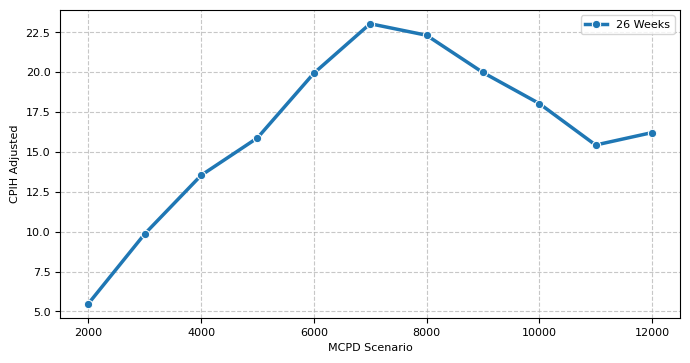

,forecast_quarter,forecast_week,mcpd_scenario,submarket_id,spending,applicants,new_dx,cost_per_new_dx,marginal_cost_per_new_dx,new_dx_ratio_daco,horizon_spend,inc_spend,inc_applicants,inc_new_dx,inc_hours_lifetime,cpih,mCPA,mCPD
0,2025-10-01,2025-10-06,1000,0,4.046517e+05,7231.909608,1489.809572,271.613045,NaN,0.206005,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-10-01,2025-10-06,2000,0,1.121009e+06,10259.509232,2074.088267,540.483019,1226.054930,0.202163,0,716357.774168,3027.599625,908.279887,154407.580866,5.482921,236.609150,788.697167
2,2025-10-01,2025-10-06,3000,0,1.906810e+06,12106.716271,2433.976105,783.413623,2183.459585,0.201043,0,785800.550212,1847.207039,554.162112,94207.558969,9.857737,425.399283,1417.997611
3,2025-10-01,2025-10-06,4000,0,2.657921e+06,13393.380895,2676.873171,992.920063,3092.301808,0.199865,0,751111.037960,1286.664624,385.999387,65619.895826,13.527554,583.765982,1945.886607
4,2025-10-01,2025-10-06,5000,0,3.321243e+06,14361.534613,2852.303110,1164.407433,3781.121233,0.198607,0,663321.864027,968.153718,290.446115,49375.839635,15.876709,685.141059,2283.803531
5,2025-10-01,2025-10-06,6000,0,3.873505e+06,15003.756642,2973.633237,1302.616843,4551.728516,0.198193,0,552261.798913,642.222029,192.666609,32753.323454,19.926925,859.923476,2866.411586
6,2025-10-01,2025-10-06,7000,0,4.372558e+06,15505.805168,3073.524200,1422.652750,4995.976582,0.198218,0,499052.916592,502.048526,150.614558,25604.474848,23.034638,994.033227,3313.444088
7,2025-10-01,2025-10-06,8000,0,4.793471e+06,15942.953650,3155.015784,1519.317589,5165.114001,0.197894,0,420913.318980,437.148482,131.144545,22294.572571,22.312292,962.861217,3209.537388
8,2025-10-01,2025-10-06,9000,0,5.153350e+06,16360.371202,3235.686129,1592.660764,4461.111059,0.197776,0,359879.368245,417.417552,125.225266,21288.295159,19.978677,862.156769,2873.855898
9,2025-10-01,2025-10-06,10000,0,5.428565e+06,16714.036599,3298.167714,1645.933568,4404.731593,0.197329,0,275214.610860,353.665397,106.099619,18036.935230,18.032644,778.177943,2593.926476


In [44]:
# one year lifetime hours

test = df_spend_to_apps[df_spend_to_apps['forecast_week'] == '2025-10-06']

test['inc_spend'] = test['spending'].diff()
test['inc_applicants'] = test['applicants'].diff()
test['inc_new_dx'] = test['inc_applicants'] * 0.3
test['inc_hours_lifetime'] = test['inc_new_dx'] * 170
test['cpih'] = test['inc_spend'] / test['inc_hours_lifetime'] * 13 / 11
test['mCPA'] = test['inc_spend'] / test['inc_applicants']
test['mCPD'] = test['inc_spend'] / (test['inc_applicants'] * 0.3)


plt.figure(figsize=(8, 4))
# mcpd_scenario
sns.lineplot(data=test, x='mcpd_scenario', y='cpih', marker='o', label='26 Weeks', linewidth=2.5)
# sns.lineplot(data=df_cpih_wad_52w_agg_q4, x='spending', y='cpih_adj', marker='o', label='52 Weeks', linewidth=2.5)
# sns.lineplot(data=df_cpih_wad_26w_agg_q4, x='spending', y='cpih_adj_lifetime', marker='o', label='Lifetime', linewidth=2.5)
# Customize the plot
# plt.title(f'{title}', fontsize=12, fontweight='bold')
plt.xlabel('MCPD Scenario', fontsize=8)
plt.ylabel('CPIH Adjusted', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=8)
# Show the plot
plt.show()

test

In [38]:
test = df_cpih_wad_26w_agg[df_cpih_wad_26w_agg['forecast_quarter'] == '2025-10-01']

test['inc_spend'] = test['spending'].diff()
test['inc_applicants'] = test['applicants'].diff()
test['inc_new_dx'] = test['new_dx_retained'].diff()
test['inc_hours'] = test['online_hours_retained'].diff()
# test['inc_hours_lifetime'] = test['inc_new_dx'] * 170
test['cpih'] = test['inc_spend'] / test['inc_hours']

test['mCPA'] = test['inc_spend'] / test['inc_applicants']
test['mCPD'] = test['inc_spend'] / test['inc_new_dx']

test

,forecast_quarter,mcpd_scenario,submarket_id,spending,applicants,new_dx_retained,online_hours_retained,inc_spend,inc_applicants,inc_new_dx,inc_hours,cpih,mCPA,mCPD
0,2025-10-01,1000,0,4.046517e+05,7231.909608,16784.302231,215639.177597,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-10-01,2000,0,1.121009e+06,10259.509232,23810.959075,305915.346495,716357.774168,3027.599625,7026.656844,90276.168898,7.935181,236.609150,101.948592
2,2025-10-01,3000,0,1.906810e+06,12106.716271,28098.081412,360994.879878,785800.550212,1847.207039,4287.122337,55079.533383,14.266652,425.399283,183.293242
3,2025-10-01,4000,0,2.657921e+06,13393.380895,31084.259212,399360.307051,751111.037960,1286.664624,2986.177800,38365.427173,19.577810,583.765982,251.529242
4,2025-10-01,5000,0,3.321243e+06,14361.534613,33331.215478,428228.459854,663321.864027,968.153718,2246.956267,28868.152803,22.977635,685.141059,295.209067
5,2025-10-01,6000,0,3.873505e+06,15003.756642,34821.727558,447378.067299,552261.798913,642.222029,1490.512079,19149.607445,28.839327,859.923476,370.518164
6,2025-10-01,7000,0,4.372558e+06,15505.805168,35986.915545,462348.018146,499052.916592,502.048526,1165.187988,14969.950847,33.336978,994.033227,428.302490
7,2025-10-01,8000,0,4.793471e+06,15942.953650,37001.479144,475382.796540,420913.318980,437.148482,1014.563599,13034.778394,32.291559,962.861217,414.871300
8,2025-10-01,9000,0,5.153350e+06,16360.371202,37970.249874,487829.243266,359879.368245,417.417552,968.770730,12446.446726,28.914226,862.156769,371.480431
9,2025-10-01,10000,0,5.428565e+06,16714.036599,38791.060314,498374.744996,275214.610860,353.665397,820.810440,10545.501731,26.097820,778.177943,335.296187


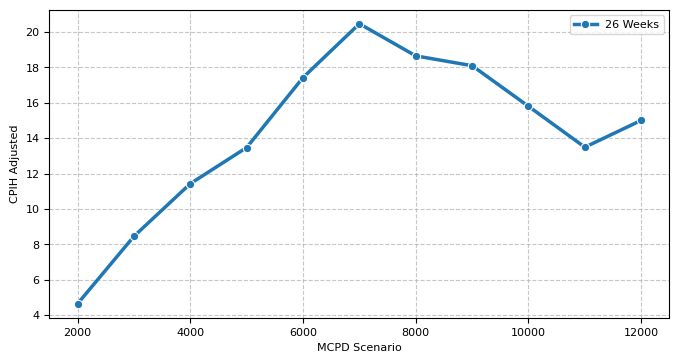

In [23]:

plt.figure(figsize=(8, 4))
# mcpd_scenario
sns.lineplot(data=test, x='mcpd_scenario', y='cpih', marker='o', label='26 Weeks', linewidth=2.5)
# sns.lineplot(data=df_cpih_wad_52w_agg_q4, x='spending', y='cpih_adj', marker='o', label='52 Weeks', linewidth=2.5)
# sns.lineplot(data=df_cpih_wad_26w_agg_q4, x='spending', y='cpih_adj_lifetime', marker='o', label='Lifetime', linewidth=2.5)
# Customize the plot
# plt.title(f'{title}', fontsize=12, fontweight='bold')
plt.xlabel('MCPD Scenario', fontsize=8)
plt.ylabel('CPIH Adjusted', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=8)
# Show the plot
plt.show()

[run_regression] Dropped 1 non‑finite rows for 'linear'.


/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


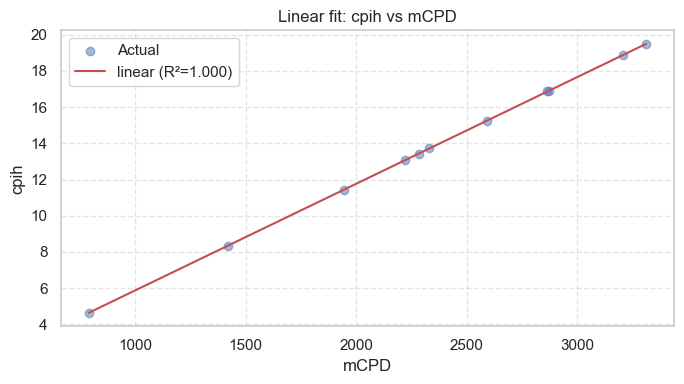

[run_regression] Dropped 1 non‑finite rows for 'log'.


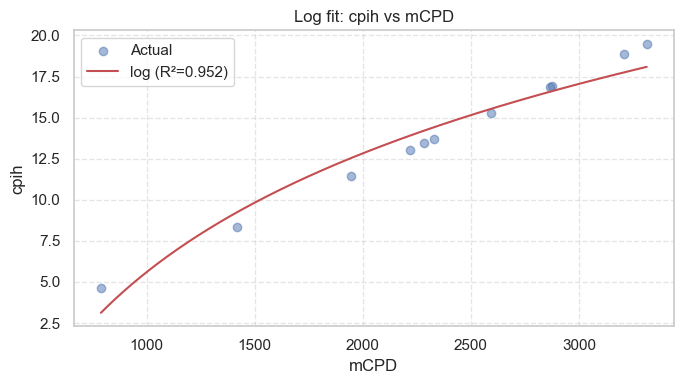

[run_regression] Auto‑selected scale=3.018e-05 for sat_exp
[run_regression] Dropped 1 non‑finite rows for 'sat_exp'.


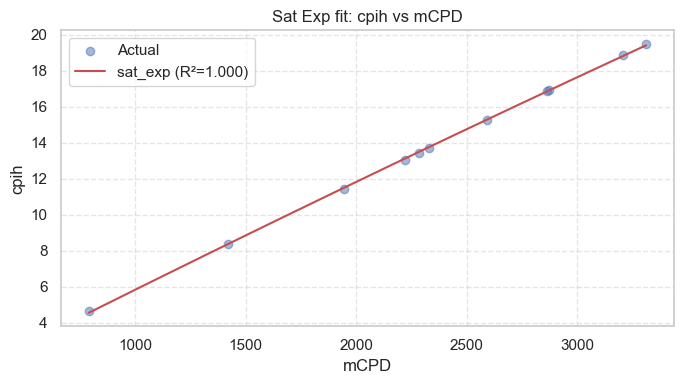

[run_regression] Dropped 1 non‑finite rows for 'hill'.


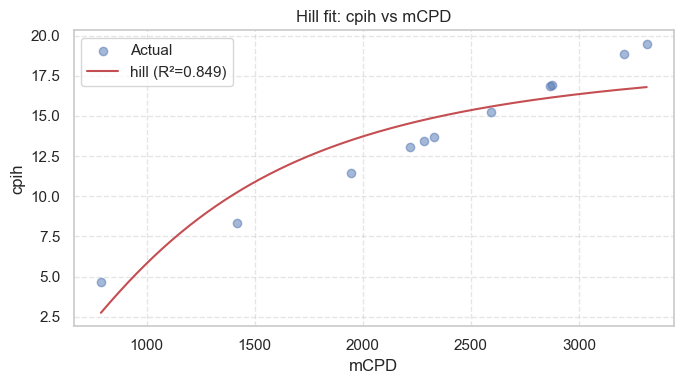


Fitted Models:
linear    : cpih = 0.006·mCPD + 0.000   (R²=1.0000)
log       : cpih = 10.428·ln(mCPD) + -66.438   (R²=0.9518)
sat_exp   : cpih = 207.603·(1 − exp(−3.02e-05·mCPD)) + -0.344   (R²=0.9998)
hill      : cpih = 26.372·(mCPD^2)/(1000^2 + mCPD^2) + -7.372   (R²=0.8488)

Best Model → linear  (R²=1.0000)


In [717]:
SHAPES = ["linear", "log", "sat_exp", "hill"]
# less good: paid_media_applicants vs cost_per_total_applicant
best_kind, best_formula, best_r2 = fit_all_curves(
    test,
    x_col="mCPD",
    y_col="cpih",
    # optional per-shape tweaks
    sat_exp=dict(scale=None),          # let auto-tune
    hill=dict(h=2, k=1000),
)

In [704]:
# Global - all SMs aggregated
submarket_id = 81

df_cpih_wad_26w_agg_q4 = run_analysis(submarket_id, daco_spend_to_applicants_curve, new_dx_landing_curve, new_dx_retention_curve, global_dx_retention)[0]
df_cpih_wad_52w_agg_q4 = run_analysis(submarket_id, daco_spend_to_applicants_curve, new_dx_landing_curve, new_dx_retention_curve, global_dx_retention)[1]
df_cpih_wad_26w = run_analysis(submarket_id, daco_spend_to_applicants_curve, new_dx_landing_curve, new_dx_retention_curve, global_dx_retention)[2]
# df_cpih_wad_52w_agg_q4 = run_analysis(submarket_id, daco_spend_to_applicants_curve, new_dx_landing_curve, new_dx_retention_curve, global_dx_retention)[1]



# plot_mcpd_and_cpih('Global - all SMs aggregated', df_cpih_wad_26w_agg_q4, df_cpih_wad_52w_agg_q4)


# caclulate the marignal

In [702]:
spend_to_apps

<function __main__.spend_to_apps(daco_spend_to_applicants_curve, submarket_id)>

In [693]:
df_cpih_wad_26w[df_cpih_wad_26w['forecast_week'] == '2025-10-06']

,forecast_quarter,forecast_week,mcpd_scenario,submarket_id,spending,applicants,online_hours_retained,new_dx_retained,new_dx_conv_52w
0,2025-10-01,2025-10-06,1000,81,6000.00000,62.335022,1858.817277,144.674046,18.565542
1,2025-10-01,2025-10-06,2000,81,21107.51979,106.632143,3179.748127,247.483726,31.758768
2,2025-10-01,2025-10-06,3000,81,41105.72579,143.256268,4271.871859,332.485066,42.666709
3,2025-10-01,2025-10-06,4000,81,60105.72579,164.410262,4902.679530,381.581607,48.967105
4,2025-10-01,2025-10-06,5000,81,81515.97379,182.970834,5456.151886,424.659044,54.495090
5,2025-10-01,2025-10-06,6000,81,93233.73798,192.899757,5752.230278,447.703191,57.452269
6,2025-10-01,2025-10-06,7000,81,99251.92898,197.646800,5893.786098,458.720656,58.866104
7,2025-10-01,2025-10-06,8000,81,104151.92898,201.762452,6016.513979,468.272718,60.091889
8,2025-10-01,2025-10-06,9000,81,109551.92898,205.793469,6136.718058,477.628350,61.292466
9,2025-10-01,2025-10-06,10000,81,113669.01738,208.878536,6228.714123,484.788518,62.211307


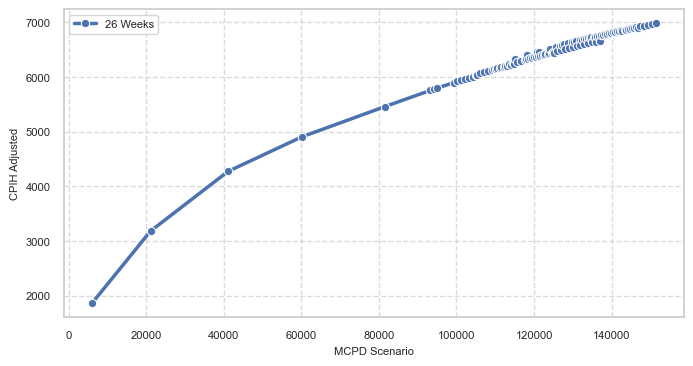

In [694]:

plt.figure(figsize=(8, 4))
# mcpd_scenario
sns.lineplot(data=df_cpih_wad_26w, x='spending', y='online_hours_retained', marker='o', label='26 Weeks', linewidth=2.5)
# sns.lineplot(data=df_cpih_wad_52w_agg_q4, x='spending', y='cpih_adj', marker='o', label='52 Weeks', linewidth=2.5)
# sns.lineplot(data=df_cpih_wad_26w_agg_q4, x='spending', y='cpih_adj_lifetime', marker='o', label='Lifetime', linewidth=2.5)
# Customize the plot
# plt.title(f'{title}', fontsize=12, fontweight='bold')
plt.xlabel('MCPD Scenario', fontsize=8)
plt.ylabel('CPIH Adjusted', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=8)
# Show the plot
plt.show()

In [695]:
def _r2_fast(y, yhat):
    """Fast R² on numpy arrays (returns -inf if y is constant)."""
    ss_tot = np.square(y - y.mean()).sum()
    if ss_tot == 0:
        return -np.inf
    ss_res = np.square(y - yhat).sum()
    return 1 - ss_res / ss_tot

def _pick_scale_sat_exp(x, y, grid=None):
    """Grid‑search the saturating‑exponential *scale* that maximises ordinary‑least‑squares R²."""
    x = x.astype(float)
    y = y.astype(float)

    if grid is None:
        x_pos = x[x > 0]
        x_max = x_pos.max()
        x_med = np.median(x_pos)
        s_min = 1.0 / (10 * x_max)
        s_max = 10.0 / x_med
        grid = np.geomspace(s_min, s_max, 25)

    best_s, best_r2 = None, -np.inf
    for s in grid:
        tr = 1.0 - np.exp(-s * x)
        X = np.vstack([np.ones_like(tr), tr]).T
        beta = np.linalg.lstsq(X, y, rcond=None)[0]
        r2 = _r2_fast(y, X @ beta)
        if r2 > best_r2:
            best_r2, best_s = r2, s

    return best_s if best_s is not None else 1.0

def run_regression(df, y, x, *, kind="linear", weights=None, bin_column=None, **kwargs):
    """Fit one curve shape via GLM and plot with a unified styling."""

    work = df.copy()


    if kind == "linear":
        reg = x
        formula = f"{y} ~ {reg}"
    elif kind == "log":
        work["_log_x"] = np.log(work[x].replace(0, np.nan))
        reg = "_log_x"
        formula = f"{y} ~ {reg}"
    elif kind == "sat_exp":
        scale = kwargs.get("scale")
        if scale is None:
            finite_mask = np.isfinite(work[[x, y]]).all(axis=1)
            scale = _pick_scale_sat_exp(work.loc[finite_mask, x].values,
                                        work.loc[finite_mask, y].values)
            print(f"[run_regression] Auto‑selected scale={scale:.4g} for sat_exp")
        work["_sat_x"] = 1.0 - np.exp(-scale * work[x])
        reg = "_sat_x"
        formula = f"{y} ~ {reg}"
    elif kind == "hill":
        h = kwargs.get("h", 1.0)
        k_param = kwargs.get("k", 1.0)
        work["_hill_x"] = (work[x] ** h) / (k_param ** h + work[x] ** h)
        reg = "_hill_x"
        formula = f"{y} ~ {reg}"
    else:
        raise ValueError("Unsupported kind: " + kind)

    mask = np.isfinite(work[[y, reg]]).all(axis=1)
    if (d := len(work) - mask.sum()) > 0:
        print(f"[run_regression] Dropped {d} non‑finite rows for '{kind}'.")
    work = work.loc[mask]
    if len(work) < 3:
        raise ValueError(f"Not enough observations for kind='{kind}'.")


    model = smf.glm(formula=formula, data=work,
                    var_weights=weights.loc[work.index] if weights is not None else None).fit()
    b1, b0 = model.params.iloc[1], model.params.iloc[0]

    # Formula string for printing
    if kind == "linear":
        fstr = f"{y} = {b1:.3f}·{x} + {b0:.3f}"
    elif kind == "log":
        fstr = f"{y} = {b1:.3f}·ln({x}) + {b0:.3f}"
    elif kind == "log_shift":
        fstr = f"{y} = {b1:.3f}·ln({x} + {shift}) + {b0:.3f}"
    elif kind == "expo":
        fstr = f"{y} = {b1:.3f}·exp({x}) + {b0:.3f}"
    elif kind == "sat_exp":
        fstr = f"{y} = {b1:.3f}·(1 − exp(−{scale:.3g}·{x})) + {b0:.3f}"
    else:  # hill
        fstr = f"{y} = {b1:.3f}·({x}^{h})/({k_param}^{h} + {x}^{h}) + {b0:.3f}"

    r2 = getattr(model, "prsquared", 1 - model.deviance / model.null_deviance)


    x_fit = np.linspace(df[x].min(), df[x].max(), 500)
    pred_df = pd.DataFrame({x: x_fit})
    # Need corresponding regressor value in pred_df
    if kind == "linear":
        pass  # reg is x itself
    elif kind == "log":
        pred_df[reg] = np.log(pred_df[x])
    elif kind == "log_shift":
        pred_df[reg] = np.log(pred_df[x] + shift)
    elif kind == "expo":
        pred_df[reg] = np.exp(pred_df[x])
    elif kind == "sat_exp":
        pred_df[reg] = 1.0 - np.exp(-scale * pred_df[x])
    else:  # hill
        pred_df[reg] = (pred_df[x] ** h) / (k_param ** h + pred_df[x] ** h)
    y_fit = model.predict(pred_df)

    # plt.figure(figsize=(7, 4))
    # plt.scatter(df[x], df[y], alpha=0.5, label="Actual")
    # plt.plot(x_fit, y_fit, "r-", label=f"{kind} (R²={r2:.3f})")
    # plt.title(f"{kind.replace('_', ' ').title()} fit: {y} vs {x}")
    # plt.xlabel(x)
    # plt.ylabel(y)
    # plt.legend()
    # plt.grid(True, linestyle="--", alpha=0.5)
    # plt.tight_layout()
    # plt.show()
    
    # === Plot ===
    import seaborn as sns
    plt.figure(figsize=(7, 4))

    if bin_column and bin_column in df.columns:
        unique_bins = df[bin_column].dropna().unique()
        palette = sns.color_palette("tab10", len(unique_bins))
        bin_color_map = dict(zip(unique_bins, palette))
        colors = df[bin_column].map(bin_color_map)

        plt.scatter(df[x], df[y], c=colors, alpha=0.5)
        # Manual legend for bin categories
        for label, color in bin_color_map.items():
            # plt.scatter([], [], c=[color], label=label)
            plt.scatter([], [], c=[color])
    else:
        plt.scatter(df[x], df[y], alpha=0.5, label="Actual")

    plt.plot(x_fit, y_fit, "r-", label=f"{kind} (R²={r2:.3f})")
    plt.title(f"{kind.replace('_', ' ').title()} fit: {y} vs {x}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    return pd.DataFrame({"metric": [y], "formula": [fstr], "r2": [round(r2, 4)]})

def fit_all_curves(df, x_col, y_col, *, shapes=None, weights=None, bin_columns = None, **per_shape_kwargs):
    """Fit multiple curve shapes and summarise the results."""
    if shapes is None:
        shapes = SHAPES

    results = []
    for kind in shapes:
        kw = per_shape_kwargs.get(kind, {})
        try:
            summ = run_regression(df, y_col, x_col, kind=kind, weights=weights, bin_column=bin_columns, **kw)
            formula = summ.loc[0, "formula"]
            r2 = summ.loc[0, "r2"]
        except Exception as err:
            print(f"[{kind}] FAILED → {err}")
            formula, r2 = None, -np.inf
        results.append((kind, formula, r2))

    print("\nFitted Models:")
    for kind, formula, r2 in results:
        if formula is not None:
            print(f"{kind:<10}: {formula}   (R²={r2:.4f})")
        else:
            print(f"{kind:<10}: <failed>")

    best_kind, best_formula, best_r2 = max(results, key=lambda t: t[2])
    if best_formula is not None:
        print(f"\nBest Model → {best_kind}  (R²={best_r2:.4f})")
    else:
        print("\nNo model fit succeeded.")

    return best_kind, best_formula, best_r2

In [696]:
df_cpih_wad_26w['online_hours_retained'] / df_cpih_wad_26w['new_dx_retained']

0      12.848312
1      12.848312
2      12.848312
3      12.848312
4      12.848312
         ...    
307    12.848312
308    12.848312
309    12.848312
310    12.848312
311    12.848312
Length: 312, dtype: float64

In [ ]:
# df_cpih_wad_26w['CPD'] = df_cpih_wad_26w['spending'] / df_cpih_wad_26w['new_dx_retained']
# df_cpih_wad_26w['CPIH'] = df_cpih_wad_26w['spending'] / df_cpih_wad_26w['online_hours_retained']

[run_regression] Dropped 1 non‑finite rows for 'linear'.


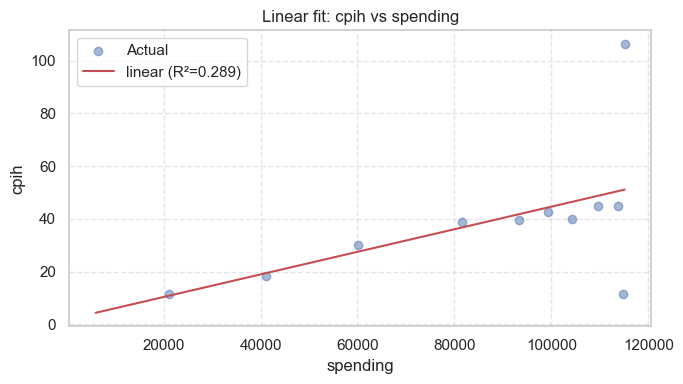

[run_regression] Dropped 1 non‑finite rows for 'log'.


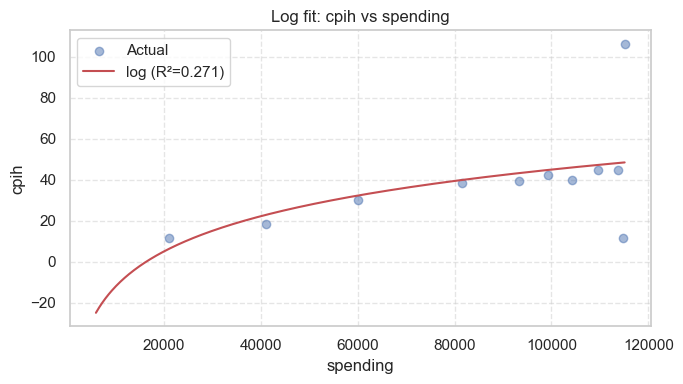

[run_regression] Auto‑selected scale=8.688e-07 for sat_exp
[run_regression] Dropped 1 non‑finite rows for 'sat_exp'.


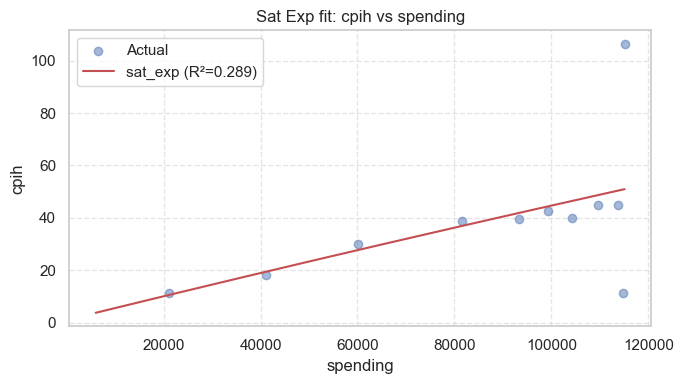

[run_regression] Dropped 1 non‑finite rows for 'hill'.


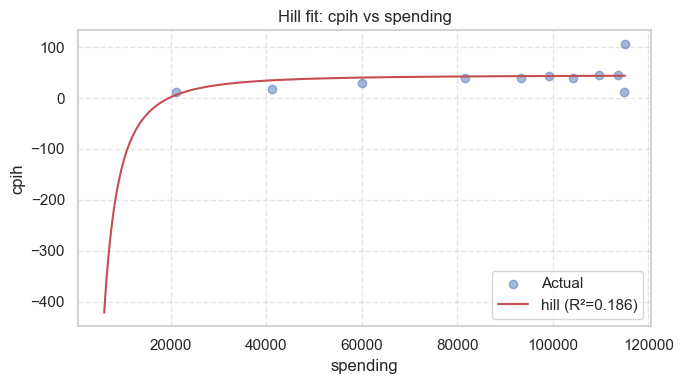


Fitted Models:
linear    : cpih = 0.000·spending + 1.779   (R²=0.2890)
log       : cpih = 24.849·ln(spending) + -241.076   (R²=0.2713)
sat_exp   : cpih = 524.331·(1 − exp(−8.69e-07·spending)) + 1.055   (R²=0.2886)
hill      : cpih = 17266.536·(spending^2)/(1000^2 + spending^2) + -17221.529   (R²=0.1863)

Best Model → linear  (R²=0.2890)


In [699]:
# # SHAPES = ["sat_exp"]
# SHAPES = ["linear", "log", "sat_exp", "hill"]
# # less good: paid_media_applicants vs cost_per_total_applicant
# best_kind, best_formula, best_r2 = fit_all_curves(
#     df_cpih_wad_26w,
#     x_col="spending",
#     y_col="new_dx_retained",
#     # optional per-shape tweaks
#     sat_exp=dict(scale=None),          # let auto-tune
#     hill=dict(h=2, k=1000),
# )

# SHAPES = ["sat_exp"]
SHAPES = ["linear", "log", "sat_exp", "hill"]
# less good: paid_media_applicants vs cost_per_total_applicant
best_kind, best_formula, best_r2 = fit_all_curves(
    test,
    x_col="spending",
    y_col="cpih",
    # optional per-shape tweaks
    sat_exp=dict(scale=None),          # let auto-tune
    hill=dict(h=2, k=1000),
)

In [ ]:
# sat_exp   : online_hours_retained = 499880.473·(1 − exp(−2.08e-07·spending)) + 217825.721   (R²=0.9465)

In [698]:
test = df_cpih_wad_26w[df_cpih_wad_26w['forecast_week'] == '2025-10-06']

test['inc_spend'] = test['spending'].diff()
test['inc_hours'] = test['online_hours_retained'].diff()
test['inc_wad'] = test['new_dx_retained'].diff()
test['inc_hours_lifetime'] = test['inc_wad'] * 12 / 11
test['cpih'] = test['inc_spend'] / test['inc_hours']
test['cpih_lifetime'] = test['inc_spend'] / test['inc_hours_lifetime']
test['cpih_adj'] = test['cpih'] * 12 / 11
test['cpih_adj_lifetime'] = test['cpih_lifetime'] * 12 / 11


test

/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_67912/2759816032.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['inc_spend'] = test['spending'].diff()
/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_67912/2759816032.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['inc_hours'] = test['online_hours_retained'].diff()
/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_67912/2759816032.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

,forecast_quarter,forecast_week,mcpd_scenario,submarket_id,spending,applicants,online_hours_retained,new_dx_retained,new_dx_conv_52w,inc_spend,inc_hours,inc_wad,inc_hours_lifetime,cpih,cpih_lifetime,cpih_adj,cpih_adj_lifetime
0,2025-10-01,2025-10-06,1000,81,6000.00000,62.335022,1858.817277,144.674046,18.565542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-10-01,2025-10-06,2000,81,21107.51979,106.632143,3179.748127,247.483726,31.758768,15107.51979,1320.930850,102.809680,112.156015,11.437025,134.700932,12.476755,146.946472
2,2025-10-01,2025-10-06,3000,81,41105.72579,143.256268,4271.871859,332.485066,42.666709,19998.20600,1092.123733,85.001340,92.728734,18.311301,215.663528,19.975964,235.269303
3,2025-10-01,2025-10-06,4000,81,60105.72579,164.410262,4902.679530,381.581607,48.967105,19000.00000,630.807671,49.096541,53.559862,30.120116,354.743256,32.858308,386.992643
4,2025-10-01,2025-10-06,5000,81,81515.97379,182.970834,5456.151886,424.659044,54.495090,21410.24800,553.472356,43.077437,46.993568,38.683500,455.599540,42.200182,497.017680
5,2025-10-01,2025-10-06,6000,81,93233.73798,192.899757,5752.230278,447.703191,57.452269,11717.76419,296.078392,23.044147,25.139070,39.576560,466.117656,43.174429,508.491989
6,2025-10-01,2025-10-06,7000,81,99251.92898,197.646800,5893.786098,458.720656,58.866104,6018.19100,141.555821,11.017464,12.019052,42.514613,500.720933,46.379578,546.241017
7,2025-10-01,2025-10-06,8000,81,104151.92898,201.762452,6016.513979,468.272718,60.091889,4900.00000,122.727880,9.552063,10.420432,39.925728,470.230028,43.555340,512.978213
8,2025-10-01,2025-10-06,9000,81,109551.92898,205.793469,6136.718058,477.628350,61.292466,5400.00000,120.204079,9.355632,10.206144,44.923600,529.093062,49.007564,577.192431
9,2025-10-01,2025-10-06,10000,81,113669.01738,208.878536,6228.714123,484.788518,62.211307,4117.08840,91.996065,7.160167,7.811092,44.752875,527.082326,48.821318,574.998901


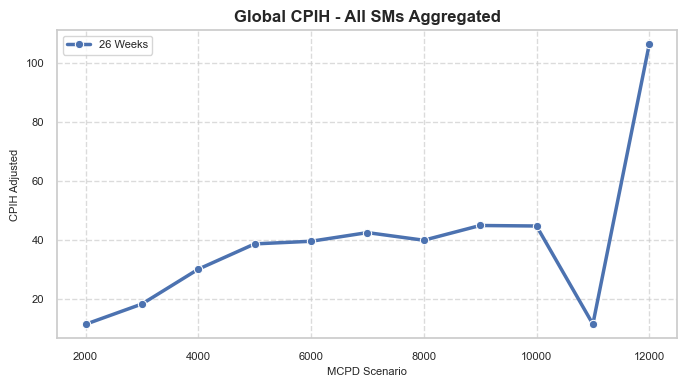

In [700]:

plt.figure(figsize=(8, 4))
# mcpd_scenario
sns.lineplot(data=test, x='mcpd_scenario', y='cpih', marker='o', label='26 Weeks', linewidth=2.5)
# sns.lineplot(data=df_cpih_wad_52w_agg_q4, x='spending', y='cpih_adj', marker='o', label='52 Weeks', linewidth=2.5)
# sns.lineplot(data=df_cpih_wad_26w_agg_q4, x='spending', y='cpih_adj_lifetime', marker='o', label='Lifetime', linewidth=2.5)
# Customize the plot
plt.title(f'Global CPIH - All SMs Aggregated', fontsize=12, fontweight='bold')
plt.xlabel('MCPD Scenario', fontsize=8)
plt.ylabel('CPIH Adjusted', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=8)
# Show the plot
plt.show()

In [701]:
# Pittsburgh
submarket_id = 81

df_cpih_wad_26w_agg_q4 = run_analysis(submarket_id, daco_spend_to_applicants_curve, new_dx_landing_curve, new_dx_retention_curve, global_dx_retention)[0]
df_cpih_wad_52w_agg_q4 = run_analysis(submarket_id, daco_spend_to_applicants_curve, new_dx_landing_curve, new_dx_retention_curve, global_dx_retention)[1]

plot_mcpd_and_cpih('SM81 - Pittsburgh', df_cpih_wad_26w_agg_q4, df_cpih_wad_52w_agg_q4)

ValueError: Could not interpret value `cpih_adj` for `y`. An entry with this name does not appear in `data`.

<Figure size 800x400 with 0 Axes>

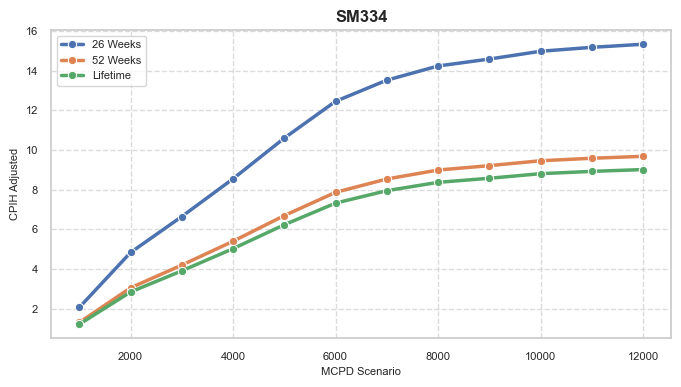

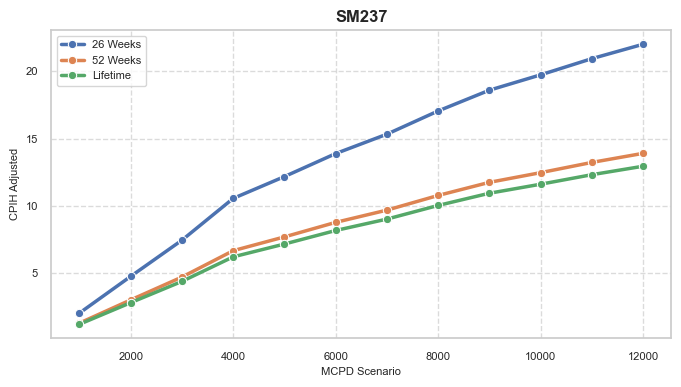

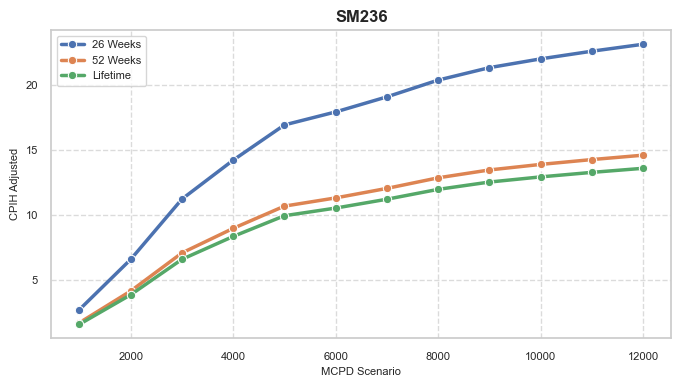

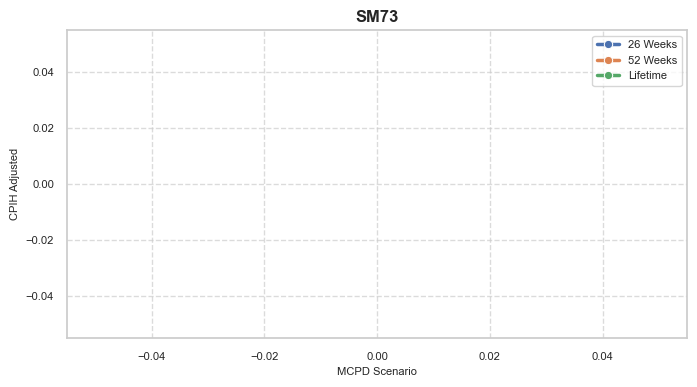

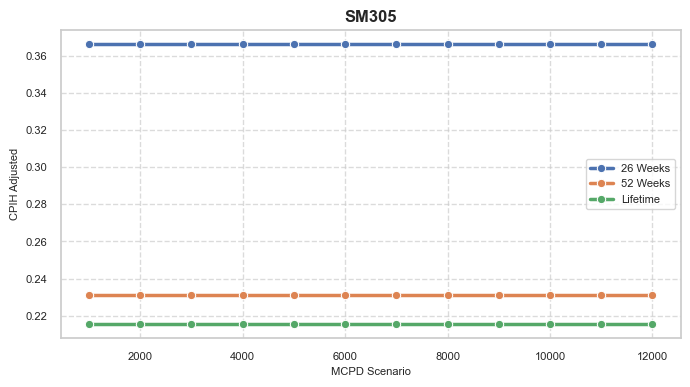

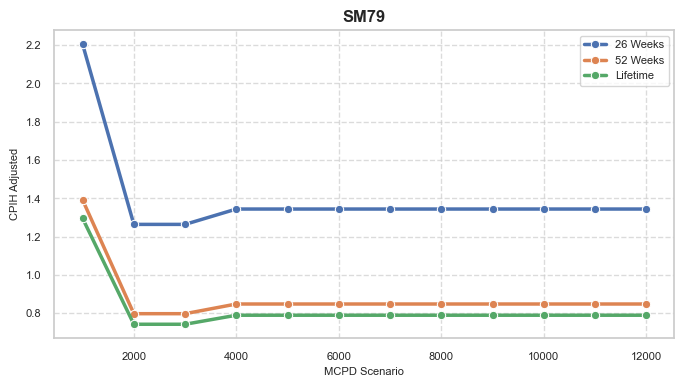

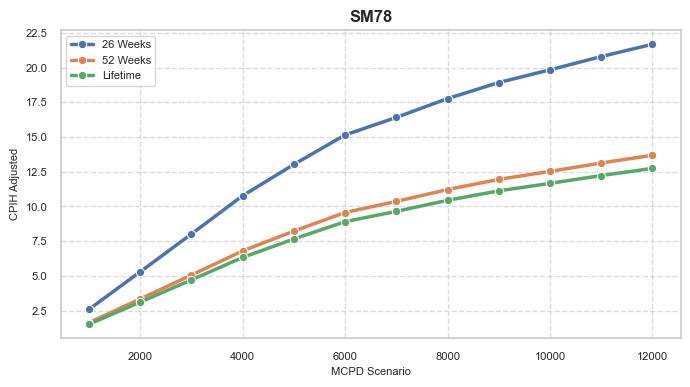

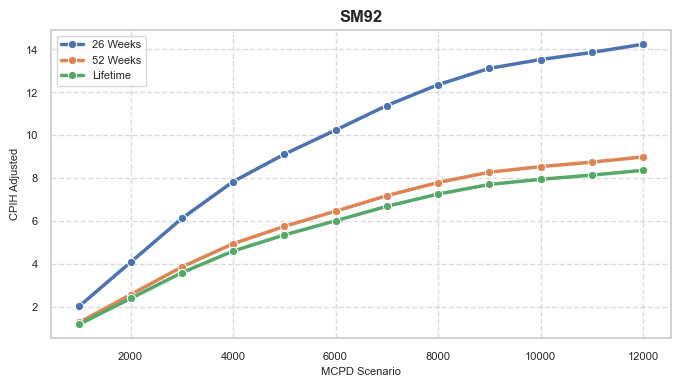

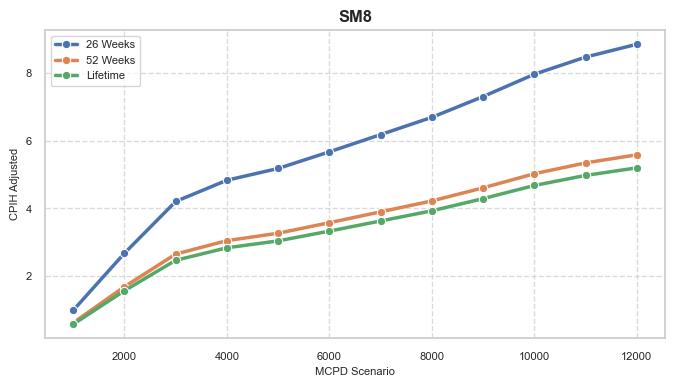

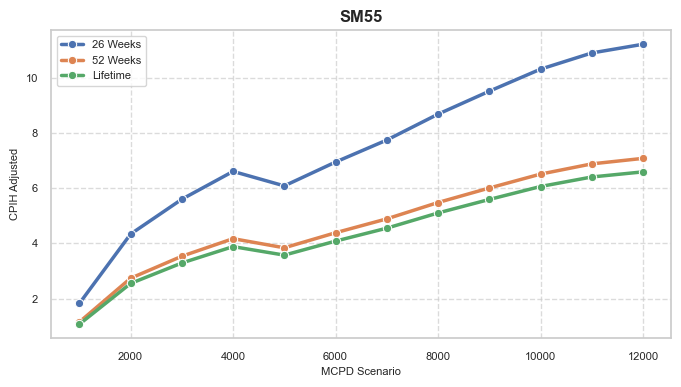

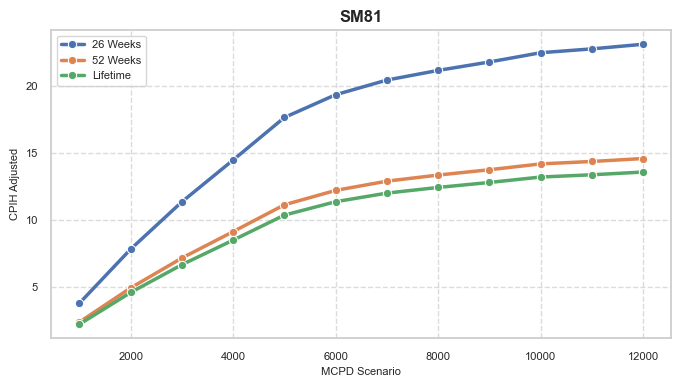

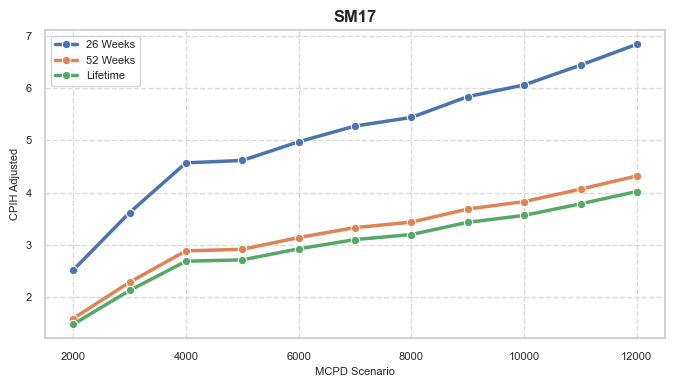

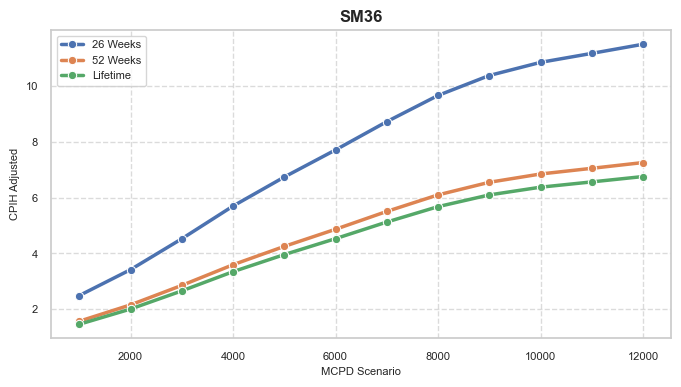

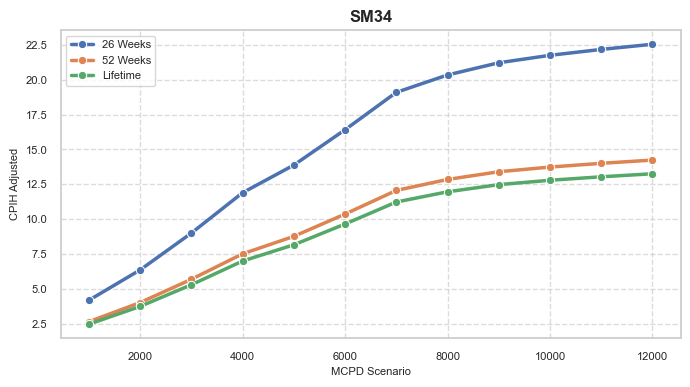

In [ ]:

# Initialize empty DataFrames to store aggregated results
df_cpih_wad_26w_agg_q4_pitts_cohort = pd.DataFrame()
df_cpih_wad_52w_agg_q4_pitts_cohort = pd.DataFrame()

# List of submarket IDs
sm_list = [334, 237, 236, 73, 305, 79, 78, 92, 8, 55, 81, 17, 36, 34]

# Loop through each submarket ID
for submarket_id in sm_list:
    # Run analysis for the current submarket ID
    df_26w, df_52w = run_analysis(submarket_id, daco_spend_to_applicants_curve, new_dx_landing_curve, new_dx_retention_curve, global_dx_retention)
    
    # Append the results to the aggregated DataFrames
    df_cpih_wad_26w_agg_q4 = pd.concat([df_cpih_wad_26w_agg_q4, df_26w], ignore_index=True)
    df_cpih_wad_52w_agg_q4 = pd.concat([df_cpih_wad_52w_agg_q4, df_52w], ignore_index=True)
    
    # Plot the results
    plot_mcpd_and_cpih(f'SM{submarket_id}', df_26w, df_52w)

In [45]:
sm_bucket = load_query('top_sm.sql')

2025-08-21 10:55:40,388 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-08-21 10:55:40,390 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-08-21 10:55:40,807 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-08-21 10:55:40,808 - utils.snowflake_connection - INFO - Executing query (pandas)


In [46]:
sm_bucket

,week,submarket_id,submarket_name,total_deliveries,uh_pct,undersupplied_hours,ideal_online_hours,uh_pct * 100,bucket_delivs,bucket_uh,total_budget,bucket_spend
0,2025-08-11,5613,"Lowell, IN",2040,0.020086,22.137064,1102.121069,2.008587,0.0,0.020,1150,0.0
1,2025-08-11,5168,"Alexander City, AL",2310,0.024083,27.664275,1148.703748,2.408304,0.0,0.024,1016,0.0
2,2025-08-11,2104,"Natchitoches, LA",3053,0.033340,51.826508,1554.463332,3.334045,0.0,0.033,2419,0.0
3,2025-08-11,5229,"Watertown, WI",3210,0.053355,71.300553,1336.337356,5.335520,0.0,0.053,1343,0.0
4,2025-08-11,1535,"Wilkesboro, NC",3350,0.031881,54.584618,1712.145348,3.188083,0.0,0.032,1512,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
146,2025-08-11,9,Dallas,969624,0.010503,4600.794239,438044.185192,1.050304,970000.0,0.011,1888,0.0
147,2025-08-11,75,Philadelphia,1050742,0.030845,14136.121626,458298.748621,3.084477,1050000.0,0.031,78827,80000.0
148,2025-08-11,23,Atlanta,1086117,0.017775,10104.096697,568440.638366,1.777511,1090000.0,0.018,180964,180000.0
149,2025-08-11,15,Houston,1156535,0.014551,8836.804142,607281.833777,1.455141,1160000.0,0.015,36580,40000.0


In [47]:
sm_bucket[sm_bucket['submarket_id'] == 81]
# bucket_uh: 0.079
# bucket_delivs: 270000.0
# bucket_spend: 80000.0

,week,submarket_id,submarket_name,total_deliveries,uh_pct,undersupplied_hours,ideal_online_hours,uh_pct * 100,bucket_delivs,bucket_uh,total_budget,bucket_spend
122,2025-08-11,81,Pittsburgh,274891,0.078853,10936.11013,138689.463819,7.885322,270000.0,0.079,77353,80000.0


In [50]:
filtered_sm_bucket = sm_bucket[
    (sm_bucket['bucket_uh'] >= 0.01) &
    (sm_bucket['bucket_delivs'] >= 150000) &
    (sm_bucket['bucket_delivs'] <= 500000) &
    (sm_bucket['bucket_spend'] >= 50000) &
    (sm_bucket['bucket_spend'] <= 100000)
]

# Display the filtered DataFrame
# filtered_sm_bucket_list = filtered_sm_bucket['submarket_id'].unique().tolist()

# filtered_sm_bucket

# check if avaialble in the daco_spend_to_applicants_curve
available_sm = filtered_sm_bucket[filtered_sm_bucket['submarket_id'].isin(daco_spend_to_applicants_curve['submarket_id'].unique())]
filtered_sm_bucket_list = available_sm['submarket_id'].unique().tolist()

available_sm




,week,submarket_id,submarket_name,total_deliveries,uh_pct,undersupplied_hours,ideal_online_hours,uh_pct * 100,bucket_delivs,bucket_uh,total_budget,bucket_spend
115,2025-08-11,236,Memphis,209654,0.050422,5370.981100,106520.708326,5.042194,210000.0,0.050,57567,60000.0
120,2025-08-11,8,Brooklyn,268893,0.051300,6062.275528,118174.140460,5.129951,270000.0,0.051,70164,70000.0
121,2025-08-11,55,Milwaukee,274160,0.061847,7461.883359,120649.766014,6.184747,270000.0,0.062,52844,50000.0
122,2025-08-11,81,Pittsburgh,274891,0.078853,10936.110130,138689.463819,7.885322,270000.0,0.079,77353,80000.0
125,2025-08-11,34,Nashville,353174,0.032706,5534.914020,169230.578378,3.270635,350000.0,0.033,55252,60000.0
128,2025-08-11,99,Virginia Beach,403401,0.058768,10658.799371,181369.793319,5.876833,400000.0,0.059,72239,70000.0
130,2025-08-11,58,Kansas City,420408,0.024085,4324.482469,179550.703162,2.408502,420000.0,0.024,67468,70000.0
133,2025-08-11,59,St. Louis,459530,0.069149,14624.558776,211493.612923,6.914894,460000.0,0.069,73851,70000.0


In [51]:
filtered_sm_bucket_list

[236, 8, 55, 81, 34, 99, 58, 59]

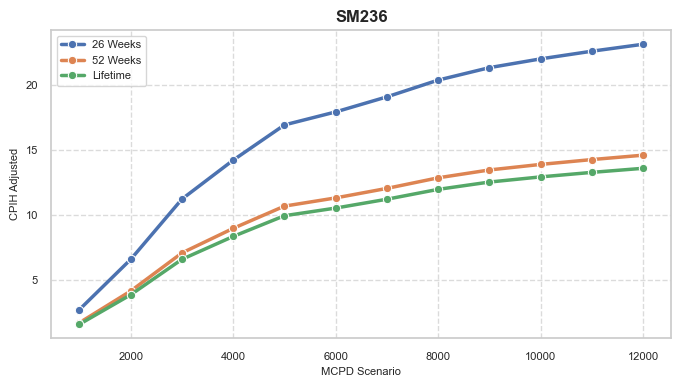

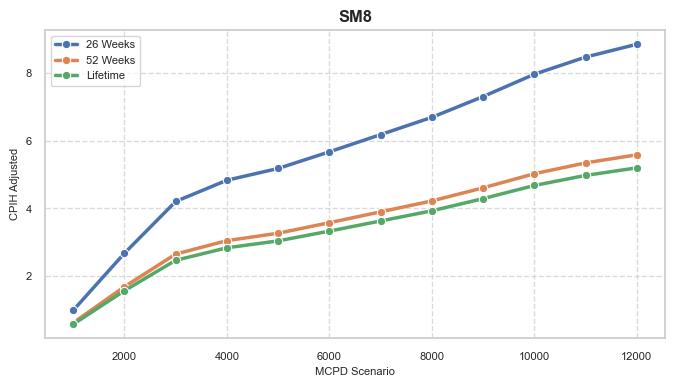

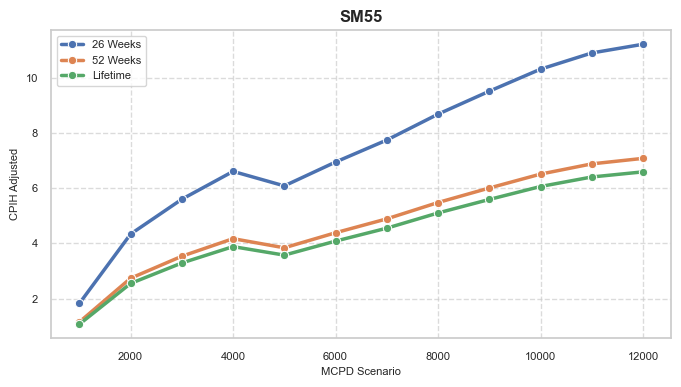

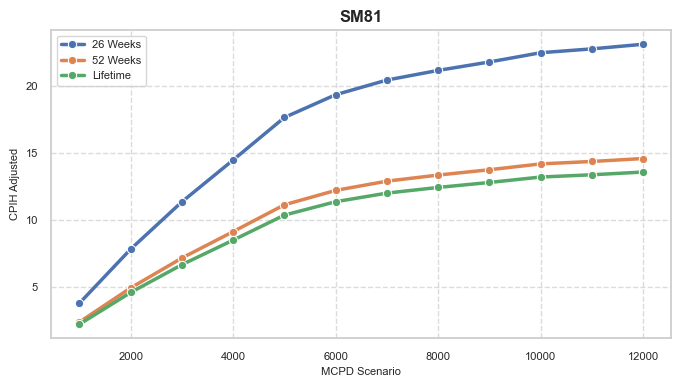

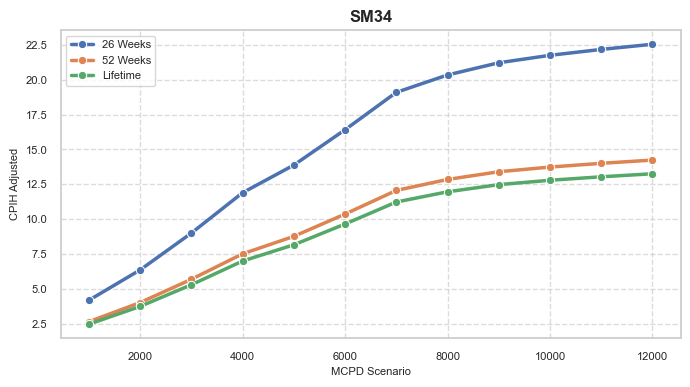

In [622]:

# Initialize empty DataFrames to store aggregated results
df_cpih_wad_26w_agg_q4_pitts_cohort = pd.DataFrame()
df_cpih_wad_52w_agg_q4_pitts_cohort = pd.DataFrame()

# List of submarket IDs
sm_list = filtered_sm_bucket_list

# Loop through each submarket ID
for submarket_id in sm_list:
    # Run analysis for the current submarket ID
    df_26w, df_52w = run_analysis(submarket_id, daco_spend_to_applicants_curve, new_dx_landing_curve, new_dx_retention_curve, global_dx_retention)
    
    # Append the results to the aggregated DataFrames
    df_cpih_wad_26w_agg_q4_pitts_cohort = pd.concat([df_cpih_wad_26w_agg_q4_pitts_cohort, df_26w], ignore_index=True)
    df_cpih_wad_52w_agg_q4_pitts_cohort = pd.concat([df_cpih_wad_52w_agg_q4_pitts_cohort, df_52w], ignore_index=True)
    
    # Plot the results
    plot_mcpd_and_cpih(f'SM{submarket_id}', df_26w, df_52w)

In [ ]:
# how diff. is the spend efficiency by SM - google 
# how sensivity is the cost curve to one week data point diff (random noise in attribution of apps in a week)

In [623]:
df_cpih_wad_26w_agg_q4_pitts_cohort

,forecast_quarter,mcpd_scenario,submarket_id,spending,cpih_adj,cpih_adj_lifetime
0,2025-10-01,1000,236,6900.000000,2.736492,1.608629
1,2025-10-01,2000,236,24100.000000,6.586936,3.872087
2,2025-10-01,3000,236,50940.705560,11.212027,6.590916
3,2025-10-01,4000,236,73074.808580,14.198097,8.346258
4,2025-10-01,5000,236,92074.808580,16.900807,9.935028
5,2025-10-01,6000,236,101900.791580,17.898448,10.521485
6,2025-10-01,7000,236,112200.791580,19.054772,11.201222
7,2025-10-01,8000,236,123599.644550,20.340386,11.956962
8,2025-10-01,9000,236,132199.644550,21.294974,12.518110
9,2025-10-01,10000,236,138302.337073,21.968321,12.913933
